In [1]:
import os
import pandas as pd
import numpy as np
from tensorflow.keras import layers
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout,BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras import mixed_precision
import pickle

In [2]:
train_csv = r"S:\Coding\Python\MiniProject\Dataset\80_20excel\train.csv"
test_csv = r"S:\Coding\Python\MiniProject\Dataset\80_20excel\test.csv"
train_img_dir = r"S:\Coding\Python\MiniProject\Dataset\80_20image\train"
test_img_dir = r"S:\Coding\Python\MiniProject\Dataset\80_20image\test"

In [3]:
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

In [4]:
IMG_SIZE = (512, 512)
BATCH_SIZE = 8

In [5]:
def build_data_pipeline(df, img_dir):
    def load_and_process(image_id, gender, year):
        img_path = tf.strings.join([img_dir, "/", image_id, ".png"])
        image = tf.io.read_file(img_path)
        image = tf.image.decode_png(image, channels=3)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0

        demo_data = tf.expand_dims(gender, axis=-1)
        return {'image_input': image, 'demo_input': demo_data}, year

    dataset = tf.data.Dataset.from_tensor_slices((
        df['id'].astype(str).values,
        df['gender'].values.astype('float32'),
        df['year'].values.astype('float32')
    ))

    dataset = dataset.map(load_and_process)
    return dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [6]:
train_data = build_data_pipeline(train_df, train_img_dir)
test_data = build_data_pipeline(test_df, test_img_dir)

In [7]:
print(f"Total training samples: {len(train_df)}")
print(f"Total testing samples: {len(test_df)}")

Total training samples: 10089
Total testing samples: 2522


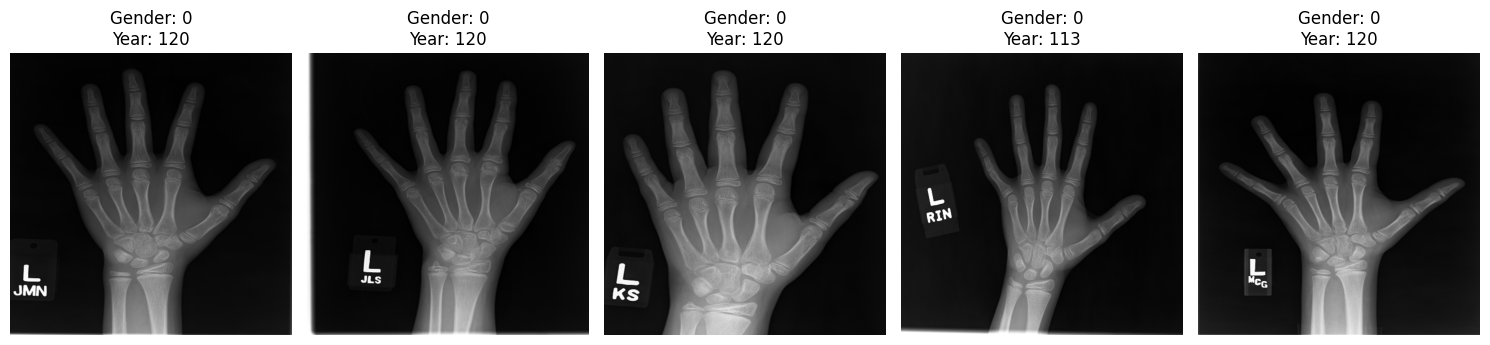

In [8]:
def show_sample_images(dataset, num_images=5):
    plt.figure(figsize=(15, 5))
    for i, (features, label) in enumerate(dataset.unbatch().take(num_images)):
        image = features['image_input']
        gender = features['demo_input'].numpy().item()
        year = label.numpy()
        plt.subplot(1, num_images, i + 1)
        plt.imshow(image)
        plt.axis('off')
        plt.title(f"Gender: {int(gender)}\nYear: {int(year)}")
    plt.tight_layout()
    plt.show()

show_sample_images(train_data)

In [9]:
def basic_block(x):
    def stem_block(x):
        x = layers.Conv2D(32, 3, strides=2, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        branch1 = layers.Conv2D(16, 1, padding='same')(x)
        branch1 = layers.BatchNormalization()(branch1)
        branch1 = layers.ReLU()(branch1)

        branch1 = layers.Conv2D(32, 3, strides=2, padding='same')(branch1)
        branch1 = layers.BatchNormalization()(branch1)
        branch1 = layers.ReLU()(branch1)

        branch2 = layers.MaxPooling2D(2, strides=2, padding='same')(x)

        x = layers.Concatenate()([branch1, branch2])
        x = layers.Conv2D(32, 1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)

        return x

    def dense_block(x, k=32):
        original_input = x

        left = layers.Conv2D(2*k, 1, padding='same')(x)
        left = layers.BatchNormalization()(left)
        left = layers.Dropout(0.1)(left)
        left = layers.ReLU()(left)
        left = layers.Conv2D(k, 3, padding='same')(left)
        left = layers.BatchNormalization()(left)
        left = layers.Dropout(0.1)(left)
        left = layers.ReLU()(left)
        left = layers.Conv2D(k, 3, padding='same')(left)
        left = layers.BatchNormalization()(left)
        left = layers.Dropout(0.1)(left)
        left = layers.ReLU()(left)

        right = layers.Conv2D(2*k, 1, padding='same')(x)
        right = layers.BatchNormalization()(right)
        right = layers.Dropout(0.1)(right)
        right = layers.ReLU()(right)
        right = layers.Conv2D(k, 3, padding='same')(right)
        right = layers.BatchNormalization()(right)
        right = layers.Dropout(0.1)(right)
        right = layers.ReLU()(right)

        x = layers.Concatenate()([left, right, original_input])
        return x

    def transition_layer(x):
        x = layers.Conv2D(256, 1, padding='same')(x)
        x = layers.BatchNormalization()(x)
        x = layers.ReLU()(x)
        x = layers.AveragePooling2D(2)(x)
        return x

    def cbam(x, ratio=16, kernel_size=7):
        channel = x.shape[-1]
        shared_dense1 = layers.Dense(channel // ratio, activation='relu')
        shared_dense2 = layers.Dense(channel)

        avg_pool = layers.GlobalAveragePooling2D()(x)
        max_pool = layers.GlobalMaxPooling2D()(x)

        avg_pool = shared_dense2(shared_dense1(layers.Reshape((1, 1, channel))(avg_pool)))
        max_pool = shared_dense2(shared_dense1(layers.Reshape((1, 1, channel))(max_pool)))

        channel_attention = layers.Activation('sigmoid')(layers.Add()([avg_pool, max_pool]))
        channel_refined = layers.Multiply()([x, channel_attention])

        avg_spatial = tf.reduce_mean(channel_refined, axis=-1, keepdims=True)
        max_spatial = tf.reduce_max(channel_refined, axis=-1, keepdims=True)
        spatial_attention = layers.Conv2D(1, kernel_size, padding='same', activation='sigmoid')(layers.Concatenate()([avg_spatial, max_spatial]))

        refined = layers.Multiply()([channel_refined, spatial_attention])
        return refined

    x = stem_block(x)
    x = dense_block(x)
    x = transition_layer(x)
    x = dense_block(x)
    x = transition_layer(x)
    x = cbam(x)
    return x

def YearRegressionModel(img_size=(128, 128)):
    # Inputs
    img_input = layers.Input(shape=(*img_size, 3), name="image_input")
    gender_input = layers.Input(shape=(1,), name="demo_input")

    # Backbone
    x = basic_block(img_input)
    x = layers.GlobalAveragePooling2D()(x)
    img_features = layers.Dense(64, activation='relu')(x)

    # Gender branch
    gender_branch = layers.Dense(16, activation='relu')(gender_input)

    # Combine
    combined = layers.Concatenate()([img_features, gender_branch])
    x = layers.Dense(64, activation='relu')(combined)
    output = layers.Dense(1, activation='linear', name='year_output')(x)

    model = Model(inputs=[img_input, gender_input], outputs=output)
    return model

In [10]:
model = YearRegressionModel(img_size=IMG_SIZE)
model.compile(optimizer=Adam(0.0001), loss='mae', metrics=['mae'])

In [11]:
base_dir = r"S:\Coding\Python\MiniProject\Models\CBAMCNN_V1"


class DualFormatSaveCallback(tf.keras.callbacks.Callback):
    def __init__(self, base_dir):
        super().__init__()
        self.base_dir = base_dir

    def on_epoch_end(self, epoch, logs=None):
        h5_path = os.path.join(self.base_dir, f"model_epoch_{epoch+1:02d}.h5")
        self.model.save(h5_path, save_format='h5')

        saved_model_path = os.path.join(self.base_dir, f"keras_savedmodel_epoch_{epoch+1:02d}")
        self.model.save(saved_model_path, save_format='tf')

dual_save_callback = DualFormatSaveCallback(base_dir)

In [12]:
initial_lr = 0.001
optimizer = tf.keras.optimizers.Adam(learning_rate=initial_lr)
lr_scheduler = ReduceLROnPlateau(
    monitor="loss",
    factor=0.5,
    patience=3,
    min_lr=1e-5,
)

In [13]:
history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=10,
    callbacks=[dual_save_callback,lr_scheduler]
)

Epoch 1/10
1262/1262 [==============================] - ETA: 0s - loss: 46.0823 - mae: 46.0823       

INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_01\assets


INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_01\assets


1262/1262 [==============================] - 146s 112ms/step - loss: 46.0823 - mae: 46.0823 - val_loss: 50.5327 - val_mae: 50.5327 - lr: 1.0000e-04
Epoch 2/10
1261/1262 [============================>.] - ETA: 0s - loss: 17.7882 - mae: 17.7882  

INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_02\assets


INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_02\assets


1262/1262 [==============================] - 141s 112ms/step - loss: 17.7868 - mae: 17.7868 - val_loss: 36.3335 - val_mae: 36.3335 - lr: 1.0000e-04
Epoch 3/10
1261/1262 [============================>.] - ETA: 0s - loss: 15.1206 - mae: 15.1206  

INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_03\assets


INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_03\assets


1262/1262 [==============================] - 141s 111ms/step - loss: 15.1191 - mae: 15.1191 - val_loss: 39.5248 - val_mae: 39.5248 - lr: 1.0000e-04
Epoch 4/10
1261/1262 [============================>.] - ETA: 0s - loss: 16.1189 - mae: 16.1189  

INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_04\assets


INFO:tensorflow:Assets written to: S:\Coding\Python\MiniProject\Models\CBAMCNN_V1\keras_savedmodel_epoch_04\assets


1262/1262 [==============================] - 142s 113ms/step - loss: 16.1177 - mae: 16.1177 - val_loss: 39.8274 - val_mae: 39.8274 - lr: 1.0000e-04
Epoch 5/10
  22/1262 [..............................] - ETA: 2:01 - loss: 7.2823 - mae: 7.2823  

KeyboardInterrupt: 